## NGN/USD Exchange Rate Forecasting

## Introduction

The foreign exchange (forex) market is a decentralized global platform for the trading of currencies, enabling international trade, investment, and financial transactions. One of the most closely monitored currency pairs in Nigeria is the exchange rate between the Nigerian Naira (₦) and the United States Dollar (USD), given the dollar's dominance in global commerce and finance. The USD/NGN exchange rate serves as a critical indicator of Nigeria’s macroeconomic stability, trade competitiveness, and investors confidence.

### Problem Statement

Over the past decade, the Nigerian Naira has experienced persistent volatility and depreciation against the US Dollar. This instability is driven by structural imbalances such as heavy dependence on oil exports, low foreign reserve buffers, restricted access to foreign exchange, and macroeconomic policy uncertainty. The resulting exchange rate unpredictability creates considerable challenges for economic planning, foreign direct investment, inflation control, and business sustainability. The absence of a reliable forecast mechanism further complicates strategic decision-making for both the public and private sectors.Therefore, it is useful to model the Naira-to-Dollar exchange rate series with the aim of understanding its historical behavior and projecting its future trajectory. The focus is on the exchange rate time series itself, independent of underlying economic drivers.


### Importance of Forecasting the USD/NGN Exchange Rate

Forecasting the future exchange rate is of significant interest to several stakeholders:

- **Government and Policy Makers**: Exchange rate forecasts are critical for formulating monetary and fiscal policies, especially in managing inflation, foreign reserves, and external debt obligations. Accurate projections can enhance macroeconomic planning and credibility.
  
- **Investors and Financial Institutions**: Both domestic and foreign investors require forward-looking exchange rate insights for portfolio allocation, risk management, and profit repatriation decisions. Financial institutions also rely on these forecasts for pricing currency derivatives and hedging exposure.

- **Importers and Exporters**: Businesses engaged in international trade depend on stable and predictable exchange rates to manage procurement costs, revenue expectations, and contract negotiations. Exchange rate uncertainty can erode profit margins and increase operational risks.

- **Multinational Corporations (MNCs)**: MNCs operating in Nigeria face translation and transaction exposure due to exchange rate fluctuations. Knowing the likely direction of the Naira helps them in budgeting, repatriation strategies, and cost optimization.

- **Households and Remittance Recipients**: For Nigerian households reliant on imported goods or foreign remittances, fluctuations in the exchange rate directly affect purchasing power and consumption patterns. Forecasts help in personal financial planning and safeguarding household welfare.

### Conclusion

Given the widespread relevance of the Naira/USD exchange rate across sectors, modeling the exchange rate series provides a practical approach to understanding its patterns and forecasting its future values. By focusing on the historical behavior of the series, a data-driven model can generate projections that inform planning, investment decisions, and exposure management without requiring detailed knowledge of underlying economic factors.

## Research Methodology

This study adopts a quantitative research design, focusing on the application of multiple machine learning algorithms to model and forecast the Naira to US Dollar (₦/$) exchange rate as a univariate time series. The methodology involves the following key steps:

### 1. Data Collection

Weekly historical exchange rate data (₦/$) will be sourced from Investing.com. The data will be cleaned, properly indexed by date, and reviewed for consistency and completeness to ensure it is suitable for time series modeling.

### 2. Data Preprocessing
The dataset will be transformed into a suitable structure for time series modeling. This will include:
- Handling missing values, if any
- Ensuring correct date indexing
- Converting the raw series into supervised learning format by creating lagged features
- Applying optional transformations (e.g., log transformation or differencing) where necessary to stabilize variance or achieve stationarity

### 3. Model Selection
Multiple machine learning algorithms will be applied to model the exchange rate series. These include:
- **Linear Regression**: For baseline performance and interpretability
- **Decision Tree Regressor**: For capturing non-linear relationships in the lagged structure
- **Random Forest Regressor**: An ensemble method to improve predictive accuracy and reduce variance
- **Gradient Boosting Machines (e.g., XGBoost, LightGBM)**: For performance comparison using advanced boosting techniques
- **Support Vector Regressor (SVR)**: For robustness to outliers and handling high-dimensional lag structures

Each model will be trained using lagged features derived from the time series to predict the next-day exchange rate.

### 4. Model Evaluation
The models will be evaluated using appropriate time series cross-validation techniques (e.g., expanding or rolling window) to ensure the temporal order is preserved. Performance metrics will include:
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- Mean Absolute Percentage Error (MAPE)

These metrics will be used to compare the predictive performance of the models.

### 5. Forecasting and Visualization
The best-performing model(s) will be used to generate short-term forecasts of the exchange rate. Forecasts will be visualized alongside actual values to assess prediction accuracy and identify any systematic deviations.

### 6. Interpretation and Documentation
The results will be interpreted based on model performance rather than economic theory, given the focus on the time series behavior of the exchange rate. A discussion of the practical implications of the forecasts for various stakeholders (e.g., investors, policymakers, businesses) will be included.

This methodological approach enables a purely data-driven examination of the Naira/USD exchange rate, leveraging machine learning to produce reliable forecasts without depending on external macroeconomic variables.

## Analysis

In [1]:
# Getting in the data

import sqlite3
import pandas as pd

def load_data_from_db(db_path: str, table_name: str, date_col: str = "date", rate_col: str = "Price") -> pd.DataFrame:
    """
    Load weekly NGN/USD exchange rate data from a remote SQLite .db file.

    Parameters:
        db_path (str): Path or URI to the .db SQLite database file.
        table_name (str): Name of the table containing the exchange rate data.
        date_col (str): Name of the date column in the table.
        rate_col (str): Name of the exchange rate column (usually 'price').

    Returns:
        pd.DataFrame: Cleaned dataframe with datetime index and one column named 'exchange_rate'.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)

    # Read the data into a DataFrame
    query = f"SELECT {date_col}, {rate_col} FROM {table_name}"
    df = pd.read_sql_query(query, conn)

    # Close the database connection
    conn.close()

    # Convert 'date' to datetime and sort
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col)

    # Set datetime index
    df.set_index(date_col, inplace=True)

    # Rename column for consistency
    df.rename(columns={rate_col: "exchange_rate"}, inplace=True)

    return df

In [2]:
df = load_data_from_db("C:/Users/USER/Documents/AKIN/PROJECTS/exchange_rate_model/data/exchange_rate_data.db",
                              table_name="ngn_usd_data")
df.head(5)

,exchange_rate
date,
2019-01-06,306.88
2019-01-13,306.80
2019-01-20,306.78
2019-01-27,306.70
2019-02-03,305.70


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, jarque_bera

sns.set(style="whitegrid")

def summarize_with_plot(df: pd.DataFrame, column: str = "exchange_rate"):
    """
    Plot the exchange rate series using seaborn and matplotlib,
    with summary statistics displayed on the chart.
    The x-axis uses automatic date formatting to avoid clutter.

    Parameters:
        df (pd.DataFrame): DataFrame with datetime index and exchange rate column.
        column (str): The name of the exchange rate column (default is 'exchange_rate').

    Returns:
        None
    """
    # Drop missing values
    series = df[column].dropna()

    # Compute summary statistics
    desc = series.describe()
    jb_stat, jb_p = jarque_bera(series)

    stats_text = (
        f"Obs: {int(desc['count'])}\n"
        f"Mean: {desc['mean']:.2f}\n"
        f"Std: {desc['std']:.2f}\n"
        f"Skew: {skew(series):.2f}\n"
        f"Kurt: {kurtosis(series, fisher=True):.2f}\n"
        f"JB p-val: {jb_p:.4f}"
    )

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=df, x=df.index, y=column, ax=ax, color="royalblue", linewidth=2)

    ax.set_title("Weekly NGN/USD Exchange Rate", fontsize=14, fontweight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Exchange Rate", fontsize=12)

    # Remove manual tick formatting
    ax.tick_params(axis='x', rotation=45)

    # Annotation box
    props = dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.9)
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

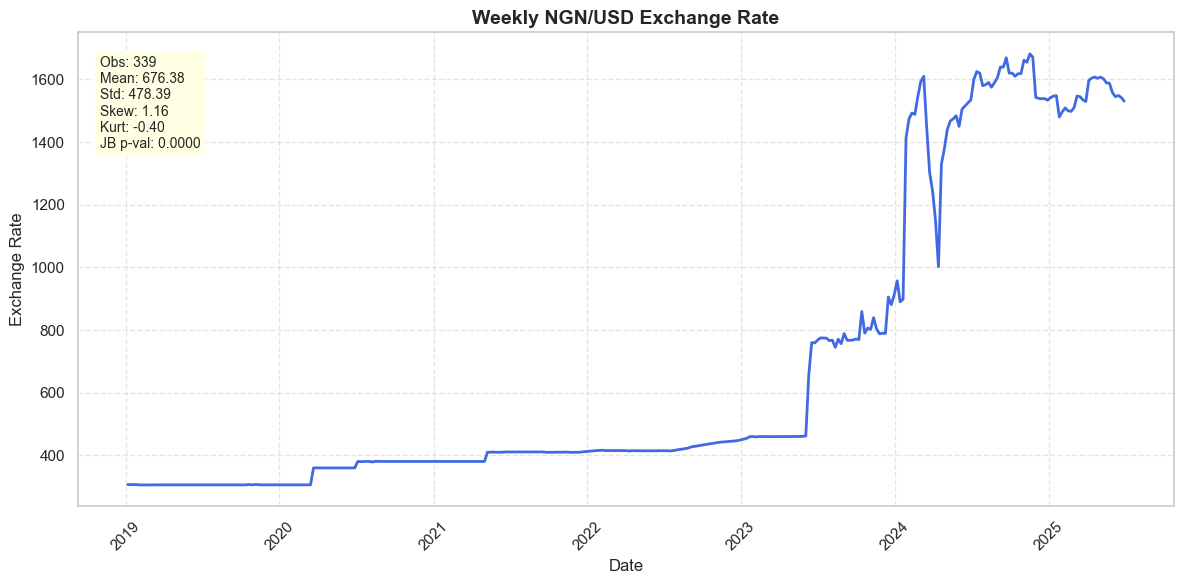

In [4]:
desc_analysis = summarize_with_plot(df)
desc_analysis

In [5]:
import numpy as np
import pandas as pd

def log_and_lag(df: pd.DataFrame, column: str = "exchange_rate", n_lags: int = 3) -> pd.DataFrame:
    """
    Log-transform the original exchange rate column (overwrite it),
    and generate lag features from the logged series.

    Parameters:
        df (pd.DataFrame): Time-indexed DataFrame with exchange rate column.
        column (str): Name of the column to log-transform and lag.
        n_lags (int): Number of lagged features to generate.

    Returns:
        pd.DataFrame: Modified DataFrame with log-transformed column and lag features.
    """
    df = df.copy()

    # Ensure the series is strictly positive before log-transforming
    if (df[column] <= 0).any():
        raise ValueError("Values must be strictly positive for log transformation.")

    # Overwrite the column with its log
    df[column] = np.log(df[column])

    # Add lag features
    for lag in range(1, n_lags + 1):
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)

    # Drop initial rows with NaN from lagging
    df.dropna(inplace=True)

    return df

In [6]:
log_lag_df = log_and_lag(df, n_lags = 4)
log_lag_df

,exchange_rate,exchange_rate_lag_1,exchange_rate_lag_2,exchange_rate_lag_3,exchange_rate_lag_4
date,,,,,
2019-02-03,5.722604,5.725870,5.726131,5.726196,5.726457
2019-02-10,5.722768,5.722604,5.725870,5.726131,5.726196
2019-02-17,5.722931,5.722768,5.722604,5.725870,5.726131
2019-02-24,5.722931,5.722931,5.722768,5.722604,5.725870
2019-03-03,5.723258,5.722931,5.722931,5.722768,5.722604
...,...,...,...,...,...
2025-06-01,7.351261,7.370199,7.370621,7.378808,7.382261
2025-06-08,7.342702,7.351261,7.370199,7.370621,7.378808
2025-06-15,7.345113,7.342702,7.351261,7.370199,7.370621


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_logged_series(df):
    """
    Plot all log-transformed exchange rate series and lagged versions from the DataFrame.

    Assumes the DataFrame contains:
    - A datetime index
    - Log-transformed series in the main column
    - Lagged versions as additional columns (e.g., exchange_rate_lag_1, lag_2, etc.)

    Parameters:
        df (pd.DataFrame): DataFrame with datetime index and log/lags.

    Returns:
        None
    """
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot all numeric series in the dataframe
    for col in df.select_dtypes(include=["float", "int"]).columns:
        linestyle = '-' if 'lag' not in col else '--'
        sns.lineplot(x=df.index, y=df[col], ax=ax, label=col, linestyle=linestyle)

    ax.set_title("Log-Transformed NGN/USD Exchange Rate and Lagged Series", fontsize=14, fontweight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("log(Exchange Rate)", fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

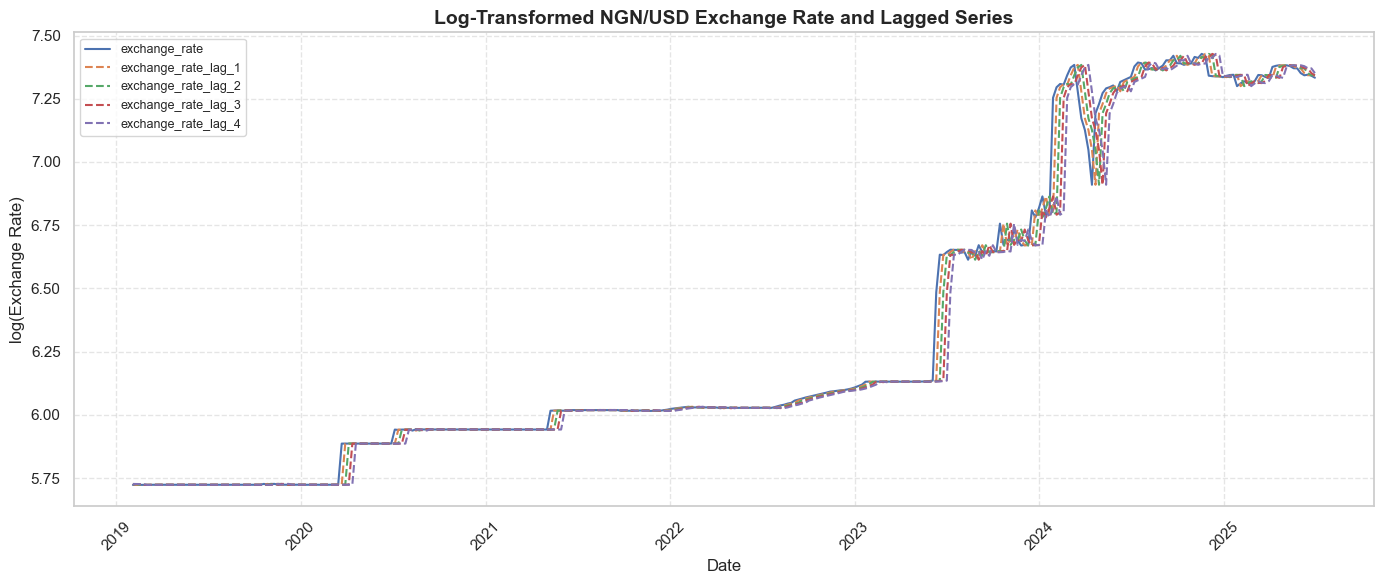

In [8]:
plot_logged_series(log_lag_df)

In [9]:
def time_series_split(df, target_column: str = "exchange_rate", test_size: float = 0.2):
    """
    Split a time series DataFrame into train and test sets with feature/target separation.

    Parameters:
        df (pd.DataFrame): Cleaned, log-transformed, and lagged DataFrame.
        target_column (str): Column name to predict (e.g., 'exchange_rate' log-transformed).
        test_size (float): Fraction of the data to reserve for testing (0 < test_size < 1).

    Returns:
        X_train, X_test, y_train, y_test (chronologically split)
    """
    if not 0 < test_size < 1:
        raise ValueError("test_size must be between 0 and 1")

    # Feature matrix: all columns except the target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Chronological split
    split_index = int(len(df) * (1 - test_size))

    X_train = X.iloc[:split_index].copy()
    X_test = X.iloc[split_index:].copy()
    y_train = y.iloc[:split_index].copy()
    y_test = y.iloc[split_index:].copy()

    return X_train, X_test, y_train, y_test

In [10]:
X_train_df, X_test_df, y_train_df, y_test_df = time_series_split(log_lag_df, "exchange_rate")

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


def train_linear_regression(X_train: pd.DataFrame, y_train: pd.Series) -> LinearRegression:
    """
    Fit a linear regression model to training data.

    Parameters:
        X_train (pd.DataFrame): Feature matrix (lagged features).
        y_train (pd.Series): Target values (log-transformed exchange rate).

    Returns:
        LinearRegression: Trained model.
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test: pd.DataFrame, y_test: pd.Series, inverse_log: bool = True) -> dict:
    """
    Predict and evaluate a regression model with optional inverse log-transform.
    Also plots actual vs predicted values on original scale.

    Parameters:
        model: Trained regression model.
        X_test (pd.DataFrame): Test feature matrix.
        y_test (pd.Series): True target values (log scale).
        inverse_log (bool): If True, apply np.exp() to predictions and actuals.

    Returns:
        dict: MAE, RMSE, R², predicted values, actual values (all in log or original scale).
    """
    y_pred = model.predict(X_test)

    if inverse_log:
        y_pred_plot = np.exp(y_pred)
        y_test_plot = np.exp(y_test)
    else:
        y_pred_plot = y_pred
        y_test_plot = y_test
        # Make sure predictions align with the actual time index
        y_pred_plot = pd.Series(y_pred_plot, index=y_test.index)
        y_test_plot = pd.Series(y_test_plot, index=y_test.index)


    # Evaluation metrics
    mae = mean_absolute_error(y_test_plot, y_pred_plot)
    rmse = root_mean_squared_error(y_test_plot, y_pred_plot)
    r2 = r2_score(y_test_plot, y_pred_plot)

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_plot, label="Actual", color="darkgreen", linewidth=2)
    plt.plot(y_pred_plot, label="Predicted", color="orange", linestyle='--', linewidth=2)
    plt.title("Actual vs Predicted Exchange Rate", fontsize=14, fontweight='bold')
    plt.xlabel("Time (Chronological Test Data)", fontsize=12)
    plt.ylabel("Exchange Rate (₦/$)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return {
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "y_pred": y_pred_plot,
        "y_actual": y_test.to_numpy()

    }

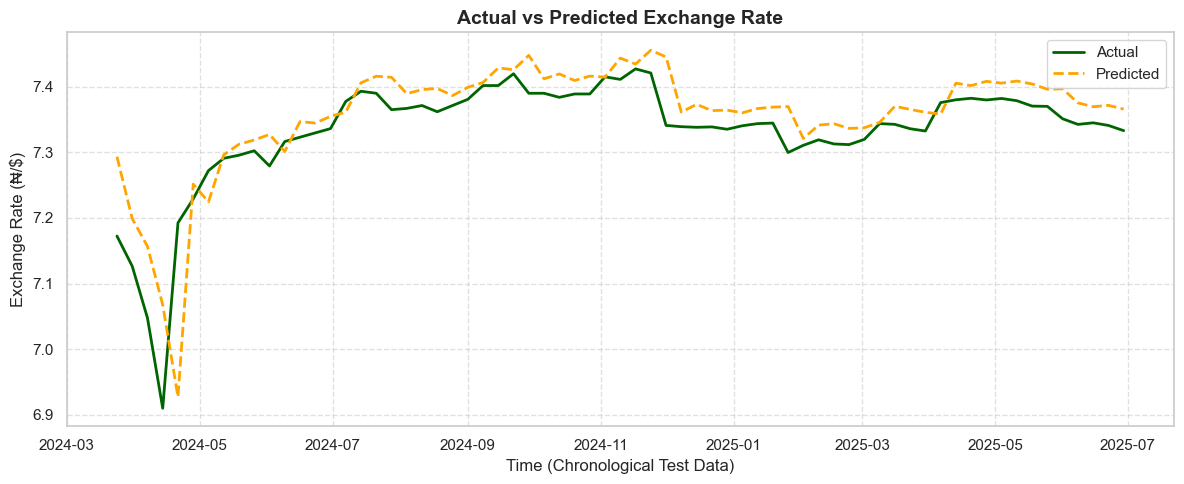

Linear Regression Evaluation:
MAE: 0.0353
RMSE: 0.0528
R2: 0.6028


In [13]:
# from exchange_rate_forecast.model import train_linear_regression, evaluate_model
# from exchange_rate_forecast.preprocessing import time_series_train_test_split

# X_train, X_test, y_train, y_test = train_linear_regression(df_logged, test_size=0.2)

model = train_linear_regression(X_train_df, y_train_df)
results = evaluate_model(model, X_test_df, y_test_df, inverse_log = False)

print("Linear Regression Evaluation:")
for k, v in results.items():
    if k in ["MAE", "RMSE", "R2"]:
        print(f"{k}: {v}")